In [10]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [11]:
# To download and use the Washington DC image:
#hsi_data.download('WashingtonDC')
#fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
hsi_data.download('MicroscenePolymers')
fname = 'spectral_images/Microscene_Polymers/reflectance_image_polymers'

In [12]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (852, 384, 452)
Shape of imList = (327168, 452)


In [13]:
# load the associated ground truth image
fname = 'ground_truth_images/reflectance_image_polymers_surfaces.txt'
file1 = open(fname, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: surge_protector_hard
Index: 0
Number of points: 1501
 
Name: ping_pong_ball
Index: 1
Number of points: 320
 
Name: red_lid
Index: 2
Number of points: 7371
 
Name: medicine_bottle_cap
Index: 3
Number of points: 252
 
Name: plastic_bottle
Index: 4
Number of points: 2862
 
Name: red_bubble_wrap
Index: 5
Number of points: 16756
 
Name: clear_bubble_wrap
Index: 6
Number of points: 9997
 
Name: PVC_plumbing_pipe
Index: 7
Number of points: 6765
 
Name: polymer_football
Index: 8
Number of points: 5503
 
Name: gloave
Index: 9
Number of points: 2759
 
Name: foil_bag
Index: 10
Number of points: 7807
 
Name: foam_packaging
Index: 11
Number of points: 21831
 


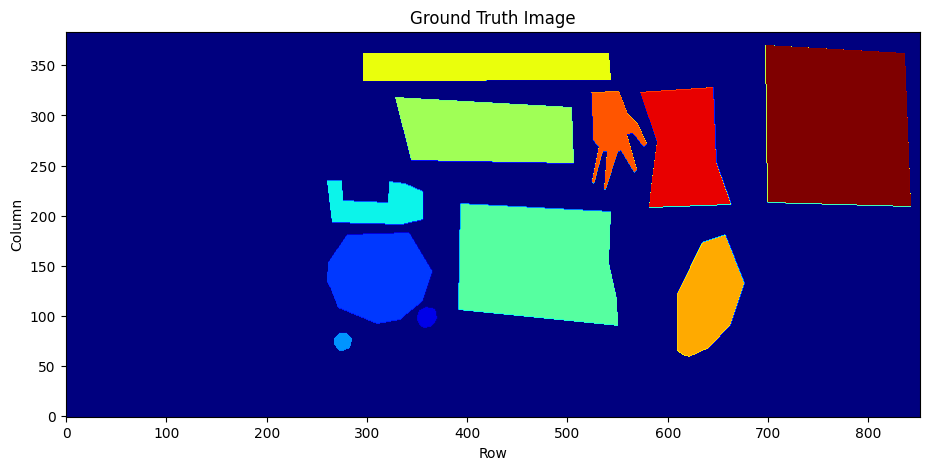

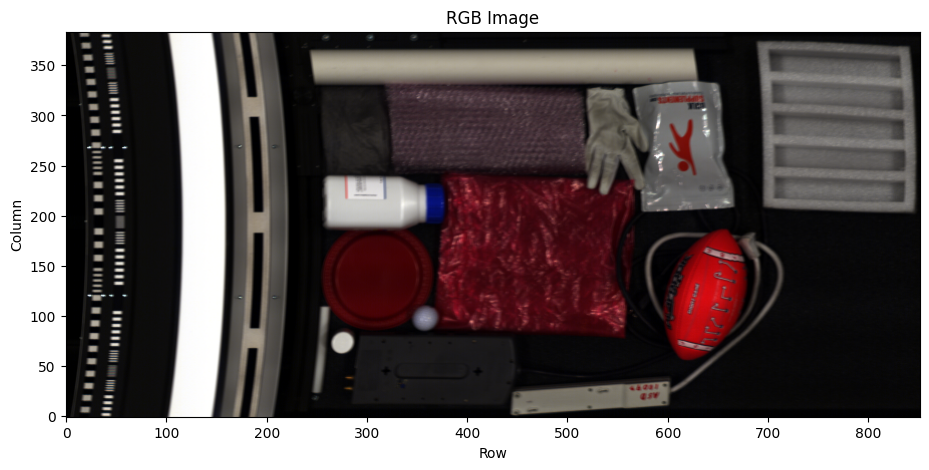

In [14]:
plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

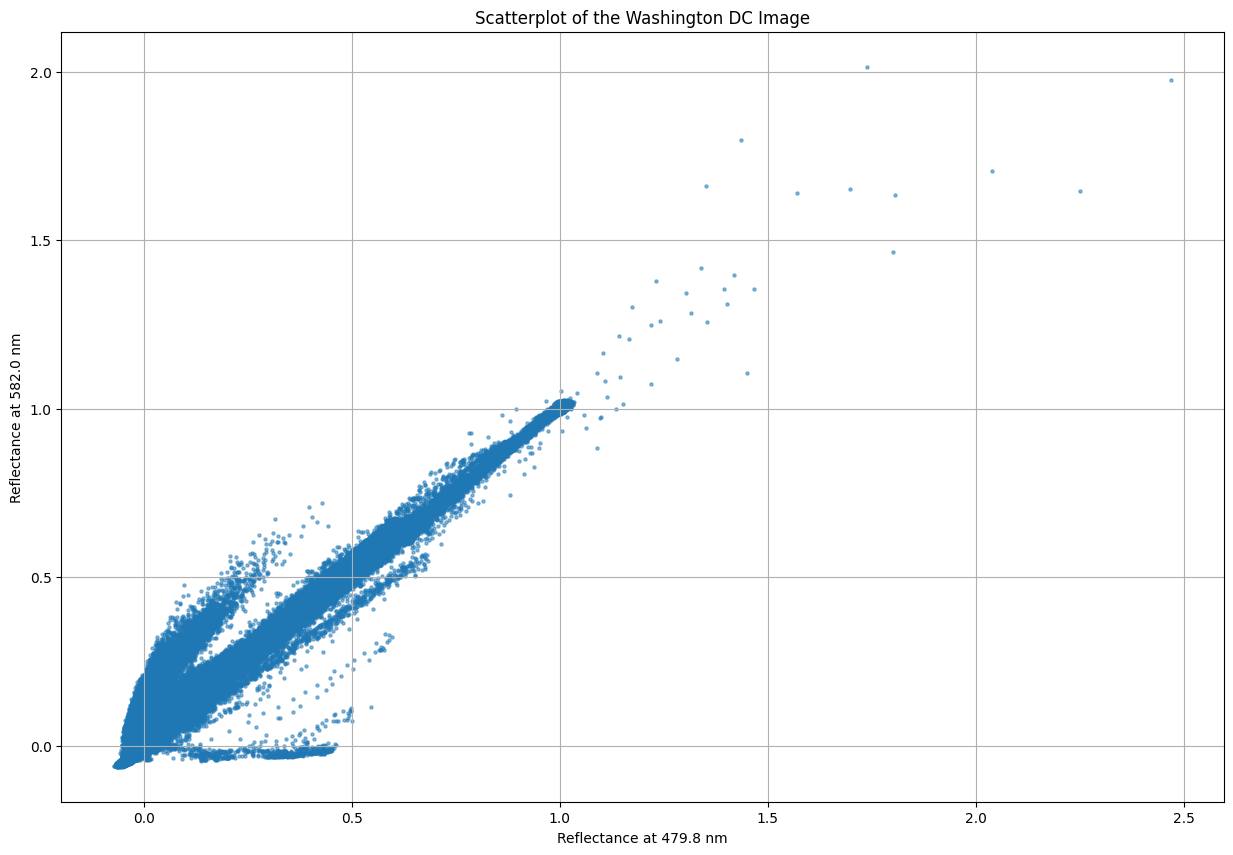

In [15]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

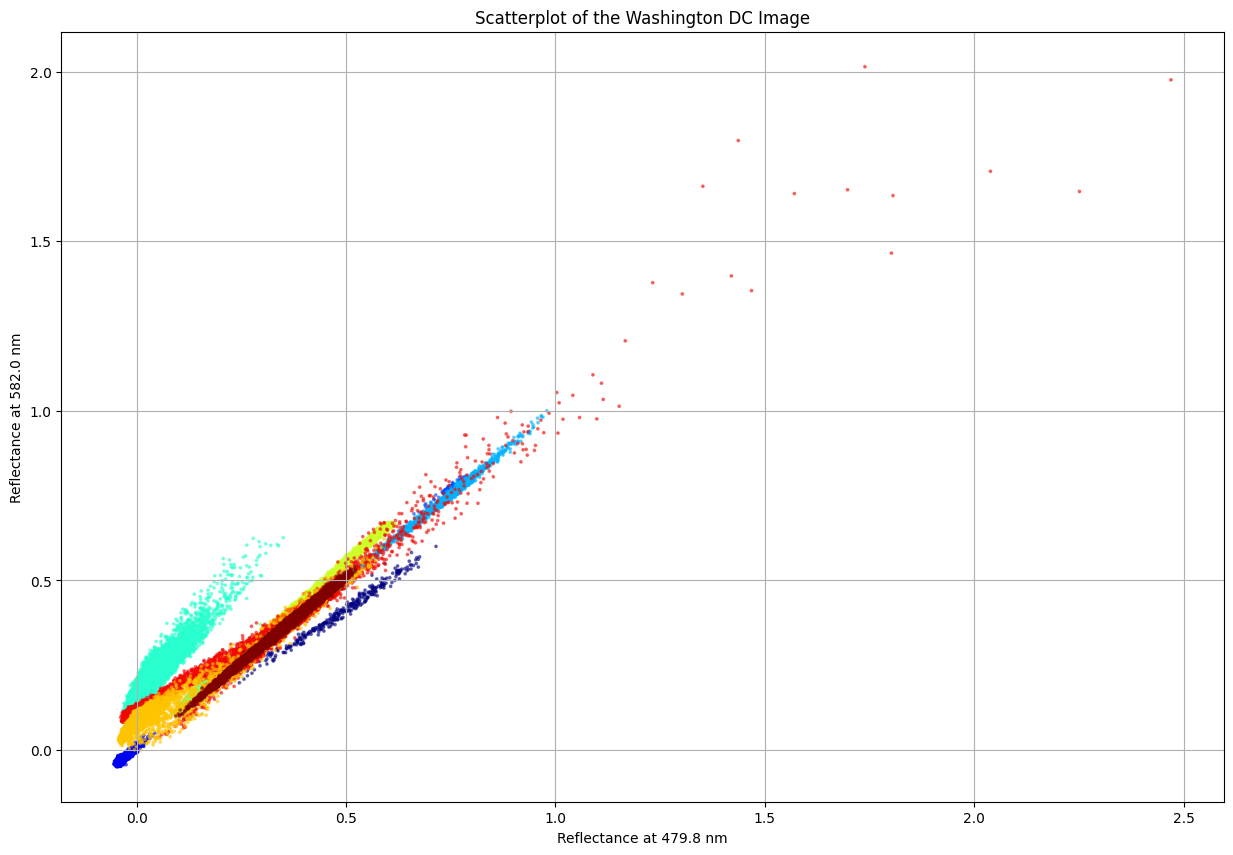

In [16]:
# Create a scatterplot of the data, colored by groundtruth class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
gt_indiexes = np.where(gt_list>0)[0] # get hte indices only for pixels in ground truth classes
plt.scatter(imList[gt_indiexes,i1], imList[gt_indiexes,i2], c=gt_list[gt_indiexes], s=3, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Examining Individual Classes

In [19]:
groundtruth_classes.keys()

dict_keys(['surge_protector_hard', 'ping_pong_ball', 'red_lid', 'medicine_bottle_cap', 'plastic_bottle', 'red_bubble_wrap', 'clear_bubble_wrap', 'PVC_plumbing_pipe', 'polymer_football', 'gloave', 'foil_bag', 'foam_packaging'])

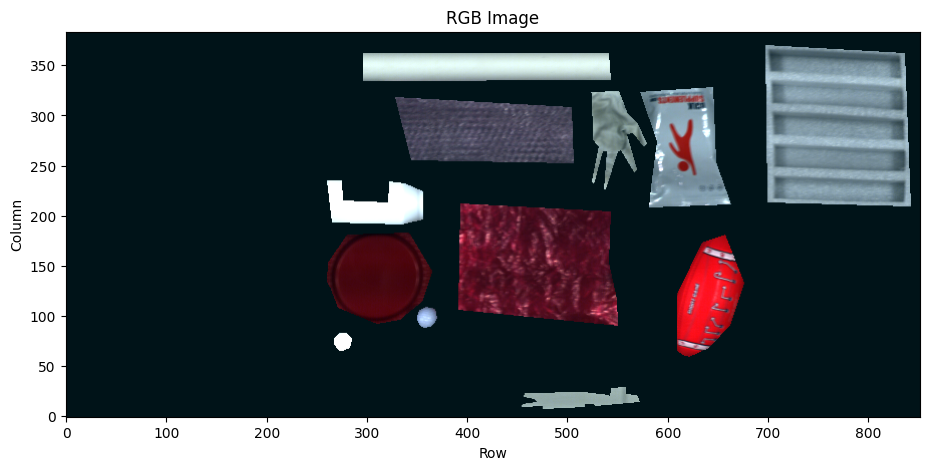

In [29]:
class_only_image = np.zeros((im.nrows, im.ncols, im.nbands))
for class_name in groundtruth_classes.keys():
    for x,y in groundtruth_classes[class_name]['locations']:
        class_only_image[int(x), int(y), :] = imArr[int(x), int(y), :]

sm2.display_RGB(class_only_image, wl, stretch_pct=[0,99], rotate=True)
plt.title('RGB Image');

In [61]:
nClasses = len(groundtruth_classes.keys())
class_means = np.zeros((nClasses, im.nbands))
C = np.zeros((im.nbands,im.nbands))

# Compute means
for class_idx, class_name in enumerate(groundtruth_classes.keys()):
    for x,y in groundtruth_classes[class_name]['locations']:
        # add to computation of class means
        spec = imArr[int(x), int(y), :].flatten()
        class_means[class_idx,:] = class_means[class_idx,:] + spec

num_pixels_all_classes = 0
for class_idx, class_name in enumerate(groundtruth_classes.keys()):
    num_pixels_in_class = len(groundtruth_classes[class_name]['locations'])
    num_pixels_all_classes = num_pixels_all_classes + num_pixels_in_class
    class_means[class_idx,:] = class_means[class_idx,:]/num_pixels_in_class


# Compute class covariance (assuming all classes have the same covariance - LDA)
for class_idx, class_name in enumerate(groundtruth_classes.keys()):
    for x,y in groundtruth_classes[class_name]['locations']:
        # add to computation of covariance
        spec = imArr[int(x), int(y), :].flatten()
        x_minus_mean = np.reshape((spec-class_means[i,:]), (im.nbands,1))
        C = C + np.matmul(x_minus_mean, x_minus_mean.T)
        
C = C / num_pixels_all_classes
         

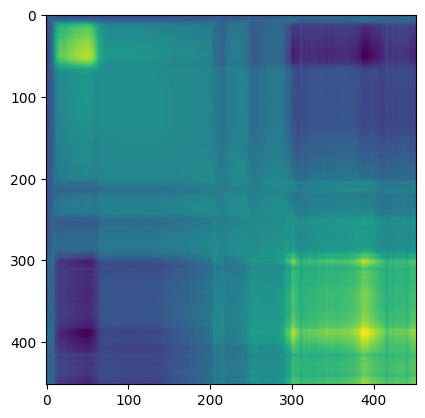

In [62]:
plt.imshow(C)

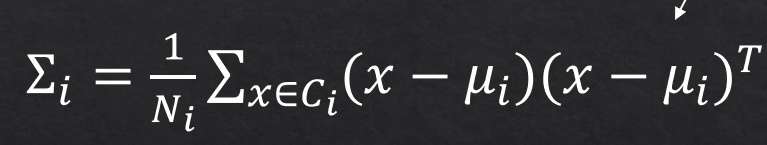

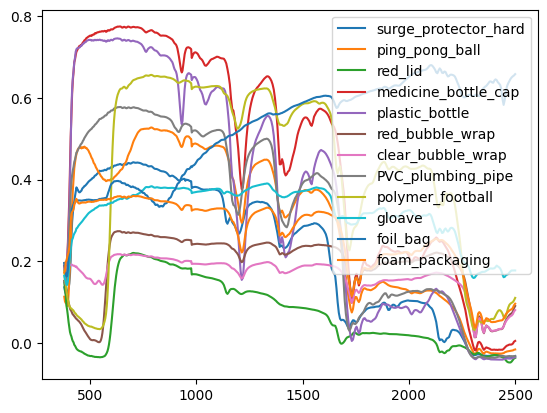

In [43]:
class_names = list(groundtruth_classes.keys())
for i in range(nClasses):
    plt.plot(wl, class_means[i,:], label=class_names[i])
plt.legend()